In [108]:
import os
import json
import regex as re
from os.path import expanduser
# from functools import lru_cache

# @lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class Encoder:
    def __init__(self, encoder, bpe_merges, errors='replace'):
        self.encoder = encoder
        self.decoder = {v:k for k,v in self.encoder.items()}
        self.errors = errors # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}
        self.special_tokens = []

        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        self.re_pattern = r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
        self.pat = re.compile(self.re_pattern)
        
    def add_special_token(self, s):
        if s in self.special_tokens:
            print(f"Token {s} already added")
        self.special_tokens.append(s)
        self.encoder[s] = len(self.encoder)+1
        self.decoder[len(self.encoder)+1] = s
        s = s.replace("|", r"\|")
        self.re_pattern = " " + s + "|" + self.re_pattern
        self.pat = re.compile(self.re_pattern)

    def bpe(self, token):
        # Also don't split on special tokens
#         print(token, token in self.special_tokens)
        if token in self.special_tokens:
            return token
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors=self.errors)
        return text

def get_encoder():
    home = expanduser("~")
    with open(os.path.join(home, 'data/GPT2/encoder.json'), 'r') as f:
        encoder = json.load(f)
    with open(os.path.join(home, 'data/GPT2/vocab.bpe'), 'r', encoding="utf-8") as f:
        bpe_data = f.read()
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
    enc = Encoder(
        encoder=encoder,
        bpe_merges=bpe_merges,
    )
    enc.add_special_token("<|endoftext|>")
    enc.add_special_token("<|GOAL|>")
    enc.add_special_token("<|PROOFSTEP|>")
    print(enc.special_tokens)
    return enc

In [117]:
import pandas as pd
df = pd.read_csv("~/data/cleaned_training_data/data_and_metadata.csv")
print(len(df))
df.head()

200298


,Unnamed: 0,goal_pp,decl_name,open_namespaces,filename,line,column,proof_key,human_tactic_code,tactic_class,cleaned_goal,split
0,0,"α : Type u,\n_inst_1 : inhabited α,\nb : buffe...",buffer.read_eq_read',buffer,lean/library/data/buffer.lean,49,30,lean/library/data/buffer.lean:49:1,cases b; unfold read read'; simp [array.read_e...,semicolon,"α : Type u,\t_inst_1 : inhabited α,\tb : buffe...",test
1,1,"α : Type u,\n_inst_1 : inhabited α,\nb : buffe...",buffer.read_eq_read',buffer,lean/library/data/buffer.lean,49,11,lean/library/data/buffer.lean:49:1,cases b; unfold read read',semicolon,"α : Type u,\t_inst_1 : inhabited α,\tb : buffe...",test
2,2,"α : Type u,\n_inst_1 : inhabited α,\ni b_fst :...",buffer.read_eq_read',buffer,lean/library/data/buffer.lean,49,13,lean/library/data/buffer.lean:49:1,unfold read read',named,"α : Type u,\t_inst_1 : inhabited α,\ti b_fst :...",test
3,3,"α : Type u,\n_inst_1 : inhabited α,\ni b_fst :...",buffer.read_eq_read',buffer,lean/library/data/buffer.lean,49,32,lean/library/data/buffer.lean:49:1,simp [array.read_eq_read'],named,"α : Type u,\t_inst_1 : inhabited α,\ti b_fst :...",test
4,4,"α : Type u,\n_inst_1 : inhabited α,\nb : buffe...",buffer.read_eq_read',buffer,lean/library/data/buffer.lean,49,4,lean/library/data/buffer.lean:49:1,cases b,named,"α : Type u,\t_inst_1 : inhabited α,\tb : buffe...",test


In [118]:
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np

prev_length = len(df)
df = df[df.goal_pp.apply(lambda x: not pd.isna(x))]
df = df.reset_index()
print(f"Dropped {prev_length - len(df)} indices")

Dropped 22 indices


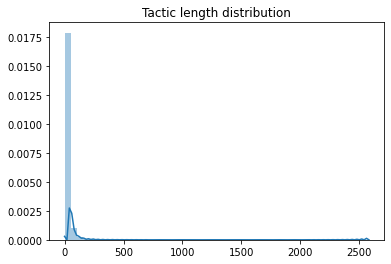

In [147]:
# Check for un-tokenizable pretty printed goals
goal_lengths = []
for i in trange(len(df)):
    try:
        tokens = enc.encode(df.cleaned_goal[i])
        if enc.decode(tokens) != df.cleaned_goal[i]:
            print("shit")
            break
        goal_lengths.append(len(tokens))
    except:
        print(f"Error at {i}, where text is {df.cleaned_goal[i]} with type {type(df.cleaned_goal[i])}")
        raise
sns.distplot(goal_lengths)
plt.title("Goal length distribution")
plt.show()

In [ ]:
# Check for un-tokenizable human written tactics
tactic_lengths = []
for i in trange(len(df)):
    try:
        tokens = enc.encode(df.human_tactic_code[i])
        if enc.decode(tokens) != df.human_tactic_code[i]:
            print("shit")
            break
        tactic_lengths.append(len(tokens))
    except:
        print(f"Error at {i}, where text is {df.human_tactic_code[i]} with type {type(df.human_tactic_code[i])}")
        raise
sns.distplot(tactic_lengths)
plt.title("Tactic length distribution")
plt.show()

In [ ]:
keep_indices = []
for i in range(len(goal_lengths)):
    if goal_lengths[i] + tactic_lengths[i] + 2 <= 1024:
        keep_indices.append(i)
print(f"Number of indices to be kept will be {len(keep_indices)} in a total of {len(goal_lengths)}")

print(f"Length before: {len(df)}")
df = df.iloc[keep_indices, :]
df.reset_index()
print(f"Length after: {len(df)}")

In [142]:
import torch
from torch.utils.data import Dataset

# Put goal and tactic into one place, extend encoder and split train test valid
class ProofStep(Dataset):
    
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.df = df
#         self.attn_masks = []
#             self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
        
    def __len__(self):
        return len(df)

    def __getitem__(self, idx):
        toks = self.tokenizer.encode(' <|GOAL|>' + self.df.cleaned_goal.iloc[i] + ' <|PROOFSTEP|>' + self.df.human_tactic_code.iloc[i]) 
        return toks#, self.attn_masks[idx] 

In [143]:
from torch.utils.data import RandomSampler, SequentialSampler

# Dataset
tokenizer = get_encoder()
dataset = ProofStep(df, tokenizer)

['<|endoftext|>', '<|GOAL|>', '<|PROOFSTEP|>']


In [144]:
from torch.utils.data import random_split

# Split into train, validation and test set: 80 - 5 - 15
train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

157,103 training samples
9,818 validation samples
29,458 test samples


In [145]:
text="It was a bright cold day in April."
quiet=False
nsamples=1
unconditional=False
batch_size=1
gradient_acc_steps = 32
length=-1
temperature=0.7
top_k=40

epochs=40
lr=1e-5
warmup_steps=200
epsilon = 1e-8

output_dir="./models" 
output_prefix="wreckgar"
test_mode=False
save_model_on_epoch=True
sample_every = 100 #sample output every 100 steps

# device=torch.device("cpu")
# model = model.cpu()

In [146]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

# Create the DataLoaders for our datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation and test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )